In [1]:
import pandas as pd
import time
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn import model_selection
import datetime
from sklearn import preprocessing
from scipy import signal
import tensorflow as tf

In [2]:
df=pd.read_csv("data/daily-minimum-temperatures-and-rain-fall.csv")
df['Date']=[datetime.datetime.strptime(t[0],"%m/%d/%y") for t in df[['Date']].values]
df['Month']= df['Date'].dt.month
df['Day']= df['Date'].dt.day
df.sort_values(by='Date',inplace=True)
df.index=df.Date

In [3]:
def replace_with_nan(x):
    if '?' in x:
        return np.nan
    else:
        return float(x)
df.Temp = df.Temp.apply(lambda x: replace_with_nan(str(x)))
df.Rain = df.Rain.apply(lambda x: replace_with_nan(str(x)))

In [4]:
def interpolate_nans(y):
    def nan_helper(y):
        return np.isnan(y), lambda z: z.to_numpy().nonzero()[0]
    nans, x = nan_helper(y)
    y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    return y

#interpolate nans 
#rain isn't used in this example
df['Temp'] = interpolate_nans(df['Temp'].copy())
df['Rain'] = interpolate_nans(df['Rain'].copy())


/Users/rohankotwani/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


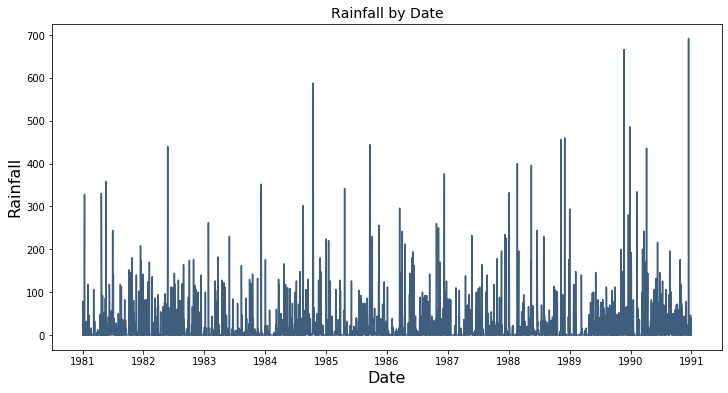

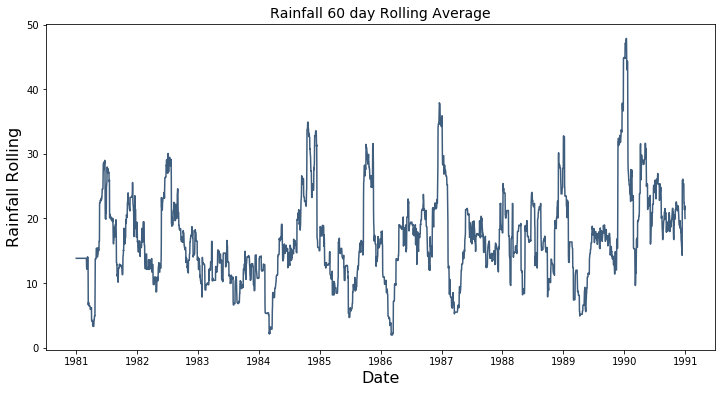

In [5]:
df['Rain_60dy_Rolling'] = df.Rain.rolling(window=60).mean()
df['Rain_60dy_Rolling'] = interpolate_nans(df['Rain_60dy_Rolling'].copy())

plt.figure(figsize=(12,6))
plt.plot(df[['Date']].values,df[['Rain']].values,color="#3F5D7D")
plt.ylabel('Rainfall',fontsize=16)
plt.xlabel('Date',fontsize=16)
plt.title('Rainfall by Date',fontsize=14)
plt.show()

plt.figure(figsize=(12,6))
plt.plot(df[['Date']].values,df[['Rain_60dy_Rolling']].values,color="#3F5D7D")
plt.ylabel('Rainfall Rolling',fontsize=16)
plt.xlabel('Date',fontsize=16)
plt.title('Rainfall 60 day Rolling Average',fontsize=14)
plt.show()

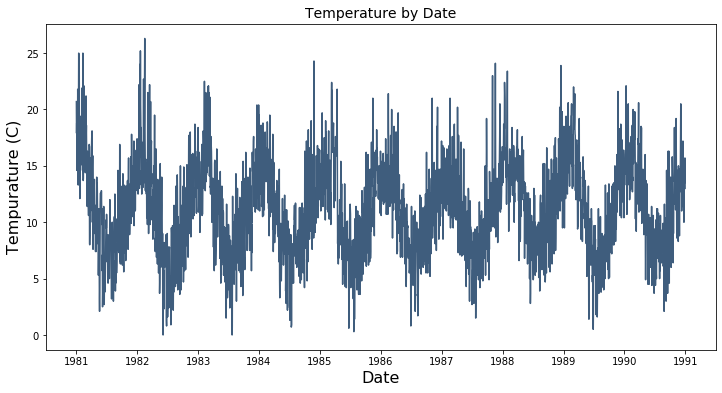

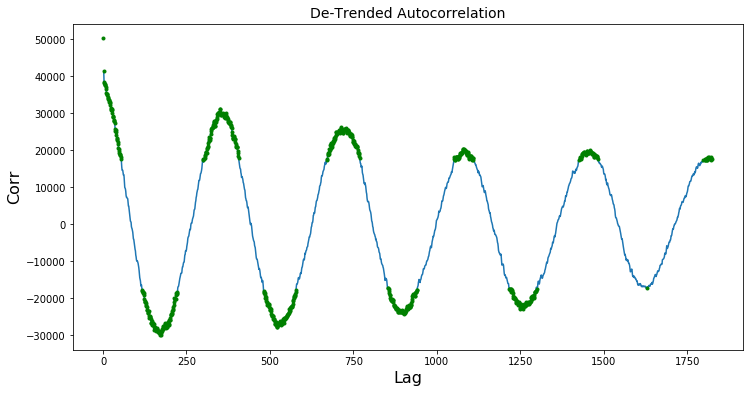

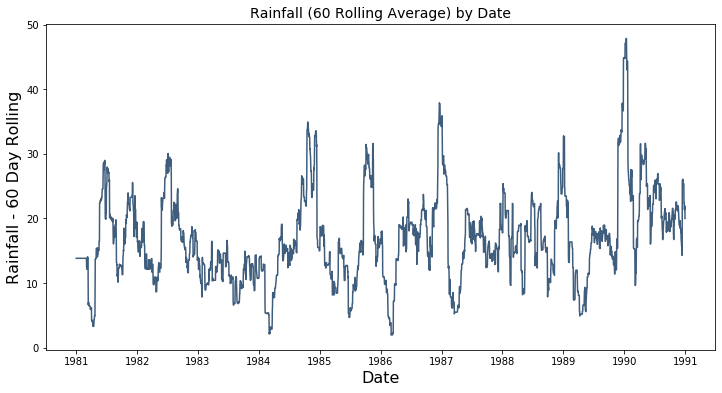

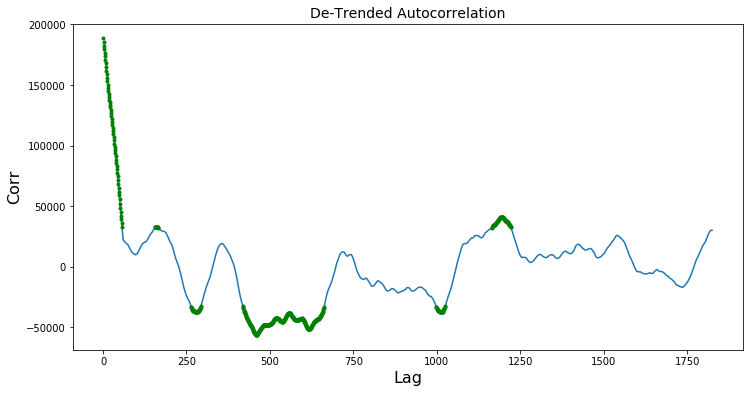

In [6]:

def autocorrelation(x):
    result = np.correlate(x, x, mode='same')
    result = result[result.size//2:]
    return result

def derivative(x):
    x = np.convolve(x,[-1,0,1],mode='full')
    x = x[1:-1]
    return x

def integral(x,w=50):
    x = np.convolve(x,np.ones(w)/w,mode='full')
    x = x[w//2:-w//2+1] 
    return x


y = df[['Temp']].values

plt.figure(figsize=(12,6))
plt.plot(df[['Date']].values,df[['Temp']].values,color="#3F5D7D")
plt.ylabel('Tempurature (C)',fontsize=16)
plt.xlabel('Date',fontsize=16)
plt.title('Temperature by Date',fontsize=14)
plt.show()


ac = autocorrelation(y.ravel())
ac = signal.detrend(ac)
t = np.arange(0,ac.size)

#exclude lag 0
ac = ac[1:]
t = t[1:]

#peak finding
d = derivative(integral(ac))
peaks = np.where(np.abs(d)<8)[0]

#get strong autocorrelation
strong_corr = np.where((ac>np.mean(ac)+np.std(ac))|(ac<np.mean(ac)-np.std(ac)))[0]
corr_peaks = t[strong_corr]

plt.figure(figsize=(12,6))
plt.plot(t[1:],ac[1:])
plt.plot(t[strong_corr],ac[strong_corr],'g.')
# plt.plot(t[peaks],ac[peaks],'r.')
plt.title('De-Trended Autocorrelation',fontsize=14)
plt.ylabel('Corr',fontsize=16)
plt.xlabel('Lag',fontsize=16)
plt.show()


y = df[['Rain_60dy_Rolling']].values

plt.figure(figsize=(12,6))
plt.plot(df[['Date']].values,df[['Rain_60dy_Rolling']].values,color="#3F5D7D")
plt.ylabel('Rainfall - 60 Day Rolling',fontsize=16)
plt.xlabel('Date',fontsize=16)
plt.title('Rainfall (60 Rolling Average) by Date',fontsize=14)
plt.show()


ac = autocorrelation(y.ravel())
ac = signal.detrend(ac)
t = np.arange(0,ac.size)

#exclude lag 0
ac = ac[1:]
t = t[1:]

#peak finding
d = derivative(integral(ac))
peaks = np.where(np.abs(d)<8)[0]

#get strong autocorrelation
strong_corr = np.where((ac>np.mean(ac)+np.std(ac))|(ac<np.mean(ac)-np.std(ac)))[0]
corr_peaks = t[strong_corr]

plt.figure(figsize=(12,6))
plt.plot(t[1:],ac[1:])
plt.plot(t[strong_corr],ac[strong_corr],'g.')
# plt.plot(t[peaks],ac[peaks],'r.')
plt.title('De-Trended Autocorrelation',fontsize=14)
plt.ylabel('Corr',fontsize=16)
plt.xlabel('Lag',fontsize=16)
plt.show()

In [ ]:

def split_into_chunks(data,lag):
    result = np.zeros((data.shape[0]-lag,lag))
    for i in range(lag,data.shape[0]):
        result[i-lag] = data[i-lag:i].ravel()
    return result


def standardize(series):
    return (series-series.mean())/series.std()

df['Rain_60dy_Rolling_Norm'] = standardize(df['Rain_60dy_Rolling'])
df['Temp_Norm'] = standardize(df['Temp'])


y = df[['Temp_Norm','Rain_60dy_Rolling_Norm']].values[lag:]


X = np.hstack([split_into_chunks(df[[col]].values,lag) for col in ['Temp_Norm',
                                                                   'Rain_60dy_Rolling_Norm']])


#The last 700 datapoints or 20% of the data was left out for validation
#These data points are excluded during training
#See code below



In [ ]:
tf.keras.backend.clear_session()

In [66]:
@tf.function
def MSE(ytrue,ypred):
    loss = tf.reduce_mean(tf.square(ypred - ytrue))
    return loss


class ARMODEL(tf.keras.Model):
    def __init__(self,shape):
        super(ARMODEL,self).__init__(name='')
        
        in_shape = shape[0]
        out_shape = shape[1]
        
        w_init = tf.random.normal(shape,mean=0,stddev=0.01,dtype='float32')
        self.w = tf.Variable(w_init,name='ar_w')
                   
    def call(self,input_X,training=False):

        return tf.matmul(input_X,self.w)+tf.reduce_sum(self.w,axis=0)


def create_model():
    
    layer_size=30
    
    input_0 = tf.keras.Input(shape=X.shape[1])

    output_0 = ARMODEL((X.shape[1],layer_size))(input_0)
    
    output_1 = ARMODEL((layer_size,y.shape[1]))(output_0)

    model = tf.keras.Model(input_0, output_1)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=MSE,
                  metrics=['mse'])
    return model

In [77]:
epochs=100
test_size = 1130

kf = model_selection.KFold(n_splits=5,shuffle=True)

data = {'X':X[:-test_size],'y':y[:-test_size]}

W =[]

epoch=0

for _ in range(epochs):
    #only get the 1st fold
    model = create_model()
    for train_index, val_index in list(kf.split(data['X']))[:1]:
        cv_train_x = data['X'][train_index]
        cv_val_x = data['X'][val_index]
        cv_train_y = data['y'][train_index]
        cv_val_y = data['y'][val_index]

        XTRAIN=cv_train_x
        XVAL=cv_val_x

        YTRAIN = cv_train_y
        YVAL = cv_val_y

        es = tf.keras.callbacks.EarlyStopping(monitor='val_mse', min_delta=0.1, patience=20,
                                         verbose=1, mode='min', baseline=None,
                                              restore_best_weights=False)

        model.fit(XTRAIN,
                      YTRAIN,
                      validation_data=(XVAL, YVAL),
                      verbose=0,
                      batch_size=100,
                      callbacks=[es],
                      epochs=1000,
                     )


        tf.saved_model.save(model,'autoregmodel/model'+str(epoch))
#         model.set_weights(w)
        YPRED = model.predict(XVAL).astype(np.float64)
        print('VAL MSE',MSE(YVAL,YPRED).numpy())
        print()
        epoch+=1



Epoch 00037: early stopping
INFO:tensorflow:Assets written to: autoregmodel/model0/assets
VAL MSE 0.28943181289498726

Epoch 00046: early stopping
INFO:tensorflow:Assets written to: autoregmodel/model1/assets
VAL MSE 0.28655621845061463

Epoch 00040: early stopping
INFO:tensorflow:Assets written to: autoregmodel/model2/assets
VAL MSE 0.25547746821682593

Epoch 00042: early stopping
INFO:tensorflow:Assets written to: autoregmodel/model3/assets
VAL MSE 0.3063692757708683

Epoch 00039: early stopping
INFO:tensorflow:Assets written to: autoregmodel/model4/assets
VAL MSE 0.29917603260306075

Epoch 00042: early stopping
INFO:tensorflow:Assets written to: autoregmodel/model5/assets
VAL MSE 0.2966961750201518

Epoch 00042: early stopping
INFO:tensorflow:Assets written to: autoregmodel/model6/assets
VAL MSE 0.2894539463762719

Epoch 00039: early stopping
INFO:tensorflow:Assets written to: autoregmodel/model7/assets
VAL MSE 0.2938633996883286

Epoch 00042: early stopping
INFO:tensorflow:Assets w

VAL MSE 0.28499572860193595

Epoch 00040: early stopping
INFO:tensorflow:Assets written to: autoregmodel/model69/assets
VAL MSE 0.2936371257876935

Epoch 00039: early stopping
INFO:tensorflow:Assets written to: autoregmodel/model70/assets
VAL MSE 0.2962855597728111

Epoch 00042: early stopping
INFO:tensorflow:Assets written to: autoregmodel/model71/assets
VAL MSE 0.25971029368135284

Epoch 00042: early stopping
INFO:tensorflow:Assets written to: autoregmodel/model72/assets
VAL MSE 0.2609194123062022

Epoch 00043: early stopping
INFO:tensorflow:Assets written to: autoregmodel/model73/assets
VAL MSE 0.29346960302826175

Epoch 00039: early stopping
INFO:tensorflow:Assets written to: autoregmodel/model74/assets
VAL MSE 0.2752205811038777

Epoch 00045: early stopping
INFO:tensorflow:Assets written to: autoregmodel/model75/assets
VAL MSE 0.2816630351541632

Epoch 00046: early stopping
INFO:tensorflow:Assets written to: autoregmodel/model76/assets
VAL MSE 0.2718676909518741

Epoch 00043: earl

In [80]:
#predict the next observation using the known samples
def predict_time_series(y,num_models):
    ts = np.zeros((num_models,y.shape[0],y.shape[1]))
    j=0
    for epoch in range(0,num_models):
        loaded = tf.saved_model.load('autoregmodel/model'+str(epoch))
        predicted = np.zeros((y.shape[0],y.shape[1]))
        predicted[:lag] = y[:lag]
        for i in range(lag,y.shape[0]):
            
            #strange way to load tf 2.0 models
            out = loaded.signatures["serving_default"]
            out._num_positional_args = 1
            out = out(tf.constant(y[i-lag:i][:].T.reshape(1,-1),'float'))
            pred = out[list(out.keys())[0]].numpy()
            
            predicted[i] = pred
        ts[j] = predicted.reshape(-1,y.shape[1])
        j+=1
    return ts

In [81]:
#create a forecast
def create_snowballed_time_series(y,num_models,forecast=0):
    ts = np.zeros((num_models,forecast,y.shape[1]))
    j=0
    for epoch in range(0,num_models):
        loaded = tf.saved_model.load('autoregmodel/model'+str(epoch))
        predicted = np.zeros((forecast,y.shape[1]))
        predicted[:lag] = y[:lag]
        for i in range(lag,forecast):
            #strange way to load tf 2.0 models
            out = loaded.signatures["serving_default"]
            out._num_positional_args = 1
            out = out(tf.constant(predicted[i-lag:i][:].T.reshape(1,-1),'float'))
            pred = out[list(out.keys())[0]].numpy()
            predicted[i] = pred
        ts[j] = predicted.reshape(-1,y.shape[1])
        j+=1
    return ts

In [82]:
max_lag = np.max(indices)

Y_full = df[['Temp_Norm','Rain_60dy_Rolling_Norm']].values[:]
Y_train = df[['Temp_Norm','Rain_60dy_Rolling_Norm']].values[:-test_size+lag]
Y_valid = df[['Temp_Norm','Rain_60dy_Rolling_Norm']].values[-test_size:]

D_full = df[['Date']][:]
D_train = df[['Date']][:-test_size+lag]
D_valid = df[['Date']][-test_size:]


forecast=365
snowball_ts_full = create_snowballed_time_series(Y_full,num_models=100,
                                                 forecast=Y_full.shape[0])

snowball_ts_valid = create_snowballed_time_series(Y_valid,num_models=100,
                                                  forecast=Y_valid.shape[0]+365)

snowball_ts_dates = np.array([D_valid.min()+datetime.timedelta(days=j)
                              for j in range(0,Y_valid.shape[0]+forecast)]).flatten()

predict_ts_train = predict_time_series(Y_train,num_models=100)

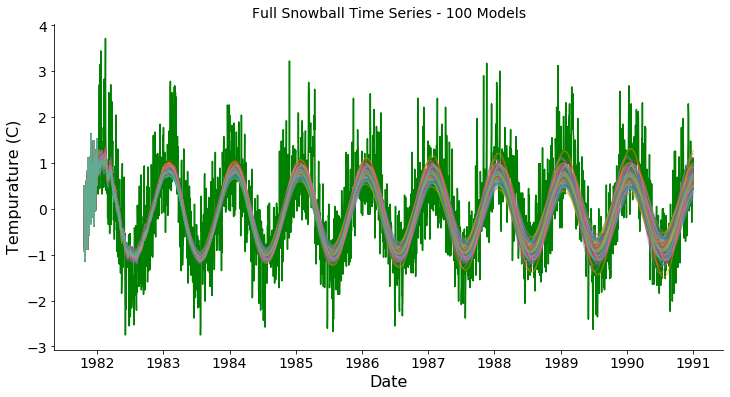

In [83]:
plt.figure(figsize=(12,6))  

ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
    
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  


plt.title("Full Snowball Time Series - 100 Models",fontsize=14)
plt.ylabel('Tempurature (C)',fontsize=16)
plt.xlabel("Date", fontsize=16)  

# plt.title('full time series prediction - mean value - tensorflow')
plt.plot(df.Date.values[max_lag:],Y_full[max_lag:,0],'g')

for i in range(snowball_ts_full.shape[0]):
    plt.plot(df.Date.values[max_lag:],snowball_ts_full[i,max_lag:,0].T,alpha=0.5)
plt.show()

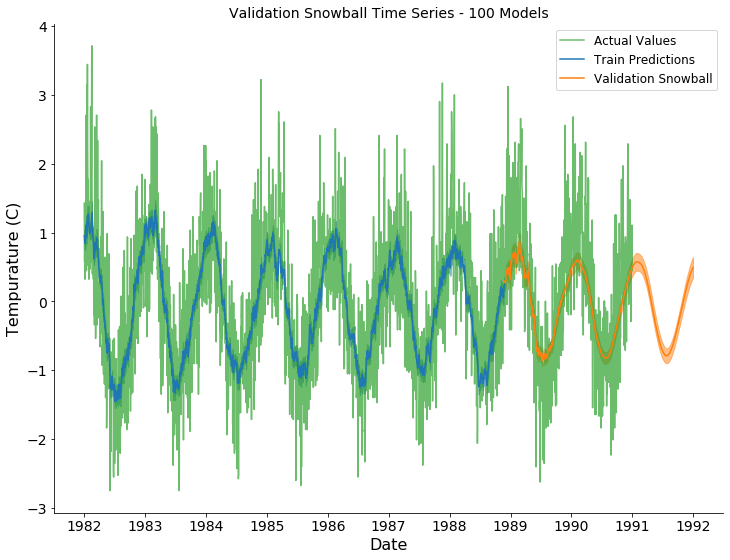

In [84]:
from matplotlib import cm

plt.figure(figsize=(12,9))  

ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  

ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  

plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  


plt.title("Validation Snowball Time Series - 100 Models",fontsize=14)
plt.ylabel('Tempurature (C)',fontsize=16)
plt.xlabel("Date", fontsize=16)  



plt.plot(df.Date[lag:].values,Y_full[lag:,0],color='#2CA02C',alpha=0.7,
                                                     label='Actual Values')

"""
Training Dataset Predictions
"""

center = np.mean(predict_ts_train,axis=0)
lower = np.mean(predict_ts_train,axis=0)-2*np.std(predict_ts_train,axis=0)
upper = np.mean(predict_ts_train,axis=0)+2*np.std(predict_ts_train,axis=0)

plt.fill_between(D_train.values.flatten()[lag:],lower[lag:,0],
                                         upper[lag:,0],color="#1F77B4",alpha=0.5)  

plt.plot(D_train.values.flatten()[lag:],center[lag:,0],color='#1F77B4',label='Train Predictions') 

# plt.vlines(np.max(D_train.values),0,25,color='black',lw=1.,alpha=1.0)


"""
Validation Dataset Snowball
"""

center = np.mean(snowball_ts_valid,axis=0)
lower = np.mean(snowball_ts_valid,axis=0)-2*np.std(snowball_ts_valid,axis=0)
upper = np.mean(snowball_ts_valid,axis=0)+2*np.std(snowball_ts_valid,axis=0)

plt.fill_between(snowball_ts_dates[lag:],lower[lag:,0],
                                         upper[lag:,0],color='#FF7F0E',alpha=0.5)  

plt.plot(snowball_ts_dates[lag:],center[lag:,0],color='#FF7F0E',label='Validation Snowball') 

plt.legend(prop={'size': 12})


plt.show()

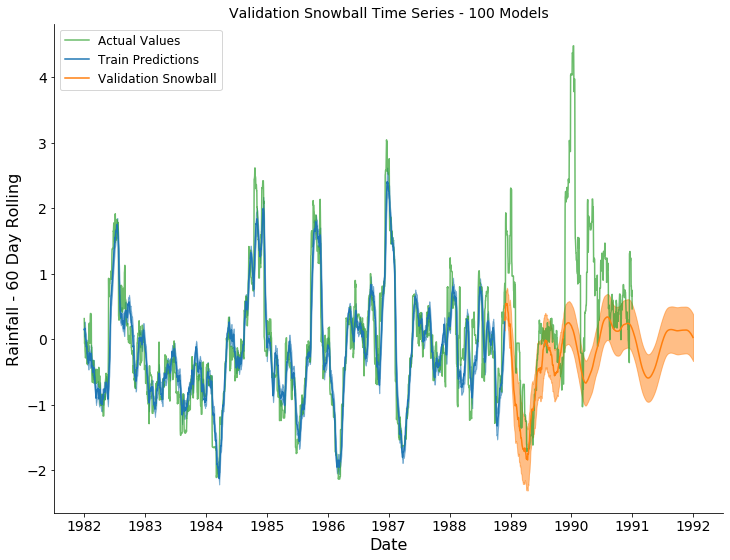

In [85]:
from matplotlib import cm

plt.figure(figsize=(12,9))  

ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  

ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  

plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  


# n = len(ax.xaxis.get_ticklabels())           # count labels
# ax.set_xticklabels([x[0] for x in np.array_split(df.Date[-700:].dt.date.values,n+1)])  # set new tick labels

plt.title("Validation Snowball Time Series - 100 Models",fontsize=14)
plt.ylabel('Rainfall - 60 Day Rolling',fontsize=16)
plt.xlabel("Date", fontsize=16)  



plt.plot(df.Date[lag:].values,Y_full[lag:,1],color='#2CA02C',alpha=0.7,
                                                     label='Actual Values')

"""
Training Dataset Predictions
"""

center = np.mean(predict_ts_train,axis=0)
lower = np.mean(predict_ts_train,axis=0)-2*np.std(predict_ts_train,axis=0)
upper = np.mean(predict_ts_train,axis=0)+2*np.std(predict_ts_train,axis=0)

plt.fill_between(D_train.values.flatten()[lag:],lower[lag:,1],
                                         upper[lag:,1],color="#1F77B4",alpha=0.5)  

plt.plot(D_train.values.flatten()[lag:],center[lag:,1],color='#1F77B4',label='Train Predictions') 

# plt.vlines(np.max(D_train.values),0,25,color='black',lw=1.,alpha=1.0)


"""
Validation Dataset Snowball
"""

center = np.mean(snowball_ts_valid,axis=0)
lower = np.mean(snowball_ts_valid,axis=0)-2*np.std(snowball_ts_valid,axis=0)
upper = np.mean(snowball_ts_valid,axis=0)+2*np.std(snowball_ts_valid,axis=0)

plt.fill_between(snowball_ts_dates[lag:],lower[lag:,1],
                                         upper[lag:,1],color='#FF7F0E',alpha=0.5)  

plt.plot(snowball_ts_dates[lag:],center[lag:,1],color='#FF7F0E',label='Validation Snowball') 

plt.legend(prop={'size': 12})


plt.show()

In [8]:
#compare results with FB Prophet
from fbprophet import Prophet

In [61]:
lag=365

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/rohankotwani/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



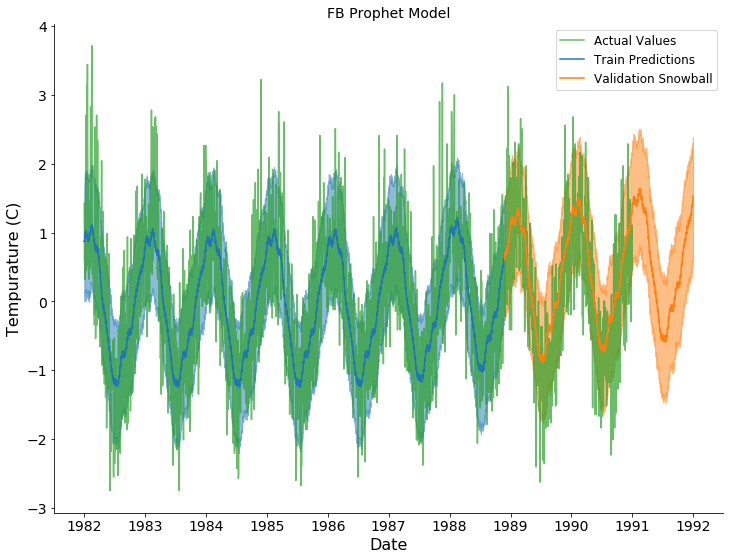

In [74]:
m = Prophet()
m.fit(df[['Date','Temp_Norm','Rain_60dy_Rolling_Norm']][:-1130+lag].rename(
    columns={'Date':'ds','Temp_Norm':'y','Rain_60dy_Rolling_Norm':'add1'}))

forecast = 765
future = m.make_future_dataframe(periods=765+365)
future.tail()

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


# fig1 = m.plot(forecast)
plt.figure(figsize=(12,9))  

plt.title("FB Prophet Model",fontsize=14)
plt.ylabel('Tempurature (C)',fontsize=16)
plt.xlabel("Date", fontsize=16)  



ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  

ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  

plt.xticks(fontsize=14)  
plt.yticks(fontsize=14) 

plt.plot(df['Date'][lag:],df['Temp_Norm'][lag:],color='#2CA02C',alpha=0.7,
                                                     label='Actual Values')



plt.plot(forecast.ds[lag:-1130],forecast.yhat[lag:-1130],color='#1F77B4',label='Train Predictions')

plt.fill_between(forecast.ds[lag:-1130],forecast.yhat_lower[lag:-1130],
                                         forecast.yhat_upper[lag:-1130],
                 color='#1F77B4',alpha=0.5)  


plt.plot(forecast.ds[-1130:],forecast.yhat[-1130:],color='#FF7F0E',label='Validation Snowball')

plt.fill_between(forecast.ds[-1130:],forecast.yhat_lower[-1130:],
                                         forecast.yhat_upper[-1130:],
                 color='#FF7F0E',alpha=0.5)  


plt.legend(prop={'size': 12})


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/rohankotwani/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



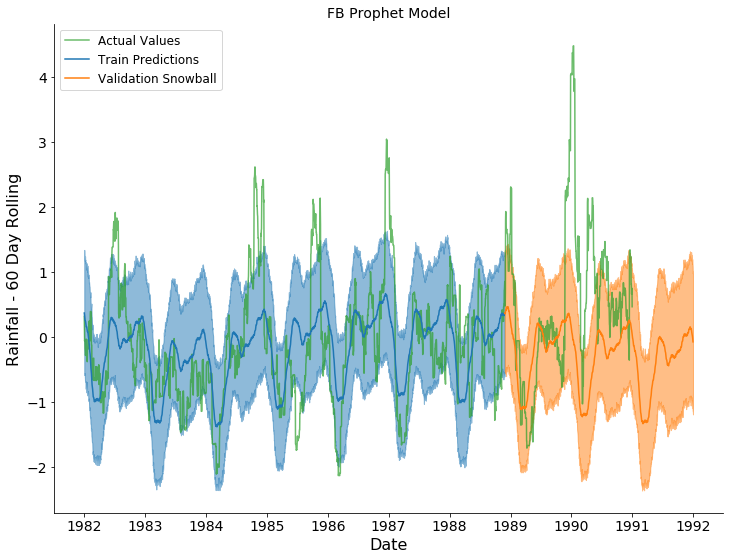

In [73]:
m = Prophet()
m.fit(df[['Date','Rain_60dy_Rolling_Norm','Temp_Norm']][:-1130+lag].rename(
    columns={'Date':'ds','Rain_60dy_Rolling_Norm':'y','Temp_Norm':'add1'}))

future = m.make_future_dataframe(periods=765+365)
future.tail()

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


# fig1 = m.plot(forecast)
plt.figure(figsize=(12,9))  

plt.title("FB Prophet Model",fontsize=14)
plt.ylabel('Rainfall - 60 Day Rolling',fontsize=16)
plt.xlabel("Date", fontsize=16)  

ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  

ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  

plt.xticks(fontsize=14)  
plt.yticks(fontsize=14) 

plt.plot(df['Date'][lag:],df['Rain_60dy_Rolling_Norm'][lag:],color='#2CA02C',alpha=0.7,
                                                     label='Actual Values')



plt.plot(forecast.ds[lag:-1130],forecast.yhat[lag:-1130],color='#1F77B4',label='Train Predictions')

plt.fill_between(forecast.ds[lag:-1130],forecast.yhat_lower[lag:-1130],
                                         forecast.yhat_upper[lag:-1130],
                 color='#1F77B4',alpha=0.5)  


plt.plot(forecast.ds[-1130:],forecast.yhat[-1130:],color='#FF7F0E',label='Validation Snowball')

plt.fill_between(forecast.ds[-1130:],forecast.yhat_lower[-1130:],
                                         forecast.yhat_upper[-1130:],
                 color='#FF7F0E',alpha=0.5)  


plt.legend(prop={'size': 12})